Урок 5. Случайный лес

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [13]:
# Сформируем датасет
from sklearn import datasets
data, labels = datasets.make_classification(n_samples=100,
                  n_features = 2, n_informative = 2, 
                  n_classes = 2, n_redundant=0, 
                  n_clusters_per_class=1, random_state=20)

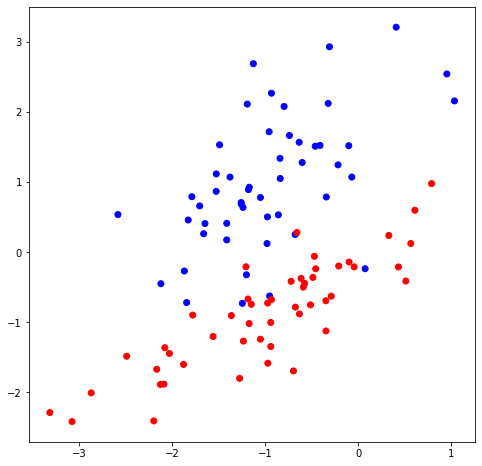

In [15]:
# Посмотрим, что там получилось
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data)), 
              c=labels, cmap=colors)

In [17]:
import random
import numpy as np

In [18]:
# Функция получения bootstrap подвыборки для построения леса
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [19]:
# Функция получения подпространства признаков
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
        
    return subsample

In [21]:
# Функционал построения дерева

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch

        
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        prediction = max(classes, key=classes.get)
        return prediction      

    
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
       
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]

    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [22]:
# Функция построения случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [23]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [38]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    data, labels, test_size = 0.3, random_state = 3)

In [104]:
# Построим требуемые леса и визуализируем гиперплоскости
random.seed(100)

In [105]:
# Одно дерево:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [106]:
# Ответы тренировочные
train_answers = tree_vote(my_forest_1, train_data)

In [107]:
# Ответы тестовые
test_answers = tree_vote(my_forest_1, test_data)

In [108]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [109]:
# Посмотрим точность на трейне:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

82.85714285714286

In [110]:
# И на тесте:
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

86.66666666666667

In [141]:
# Визуализируем:
def visualize(forest, train_data, train_labels, train_accuracy, test_data,  test_labels, test_accuracy, n_trees):
    def get_meshgrid(data, step=.1, border=2.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'{n_trees} Деревьев, Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

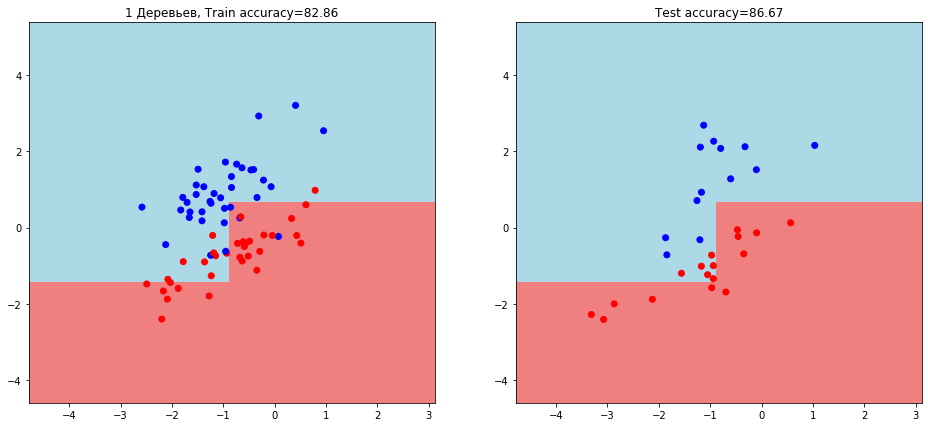

In [142]:
visualize(my_forest_1, train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy, 1)

In [60]:
# Теперь лес из трех деревьев:

In [113]:
my_forest_3 = random_forest(train_data, train_labels, n_trees=3)

In [114]:
# Ответы тренировочные
train_answers_3 = tree_vote(my_forest_3, train_data)

In [115]:
# Ответы тестовые
test_answers_3 = tree_vote(my_forest_3, test_data)

In [116]:
# Точность на трейне:
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
train_accuracy_3

92.85714285714286

In [117]:
# И на тесте:
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
test_accuracy_3

93.33333333333333

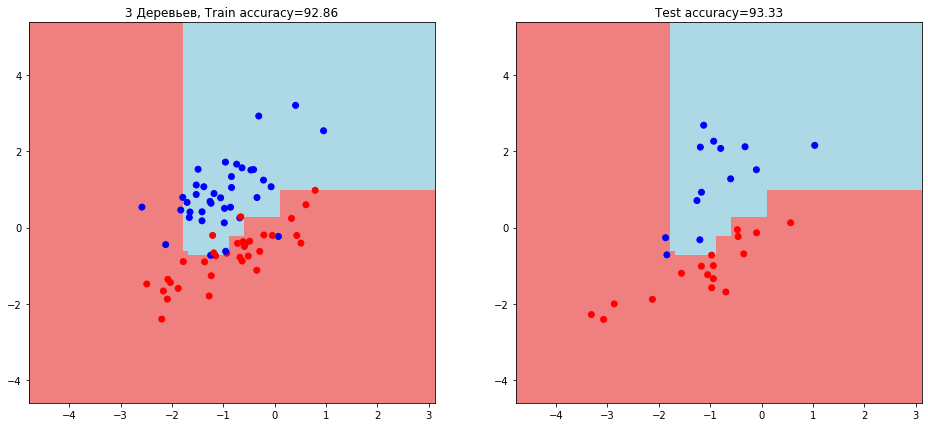

In [143]:
# Визуализируем
visualize(my_forest_3, train_data, train_labels, train_accuracy_3, test_data, test_labels, test_accuracy_3, 3)

In [119]:
# 10 деревьев
my_forest_10 = random_forest(train_data, train_labels, n_trees=10)
train_answers_10 = tree_vote(my_forest_10, train_data)
test_answers_10 = tree_vote(my_forest_10, test_data)

In [120]:
# Точность на трейне:
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
train_accuracy_10

90.0

In [121]:
# И на тесте:
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
test_accuracy_10

83.33333333333334

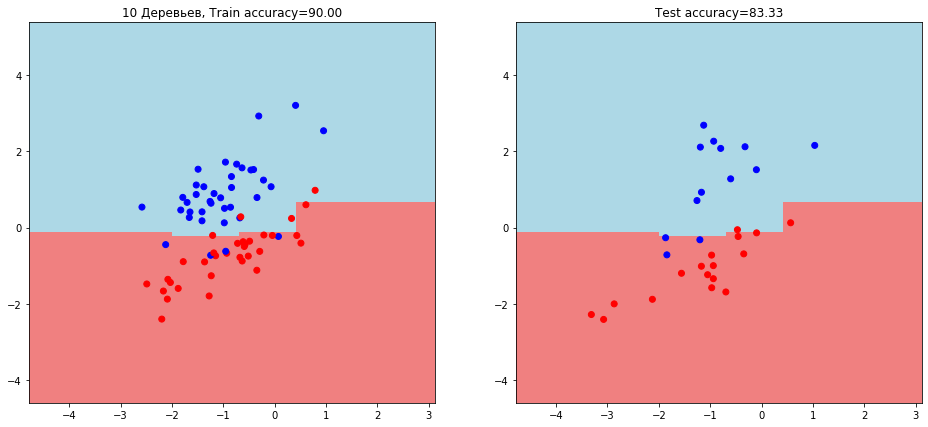

In [144]:
# Виз
visualize(my_forest_10, train_data, train_labels, train_accuracy_10, test_data, test_labels, test_accuracy_10, 10)

In [124]:
# 50 деревьев
my_forest_50 = random_forest(train_data, train_labels, n_trees=50)
train_answers_50 = tree_vote(my_forest_50, train_data)
test_answers_50 = tree_vote(my_forest_50, test_data)

In [125]:
# Точность на трейне:
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
train_accuracy_50

92.85714285714286

In [126]:
# И на тесте:
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)
test_accuracy_50

93.33333333333333

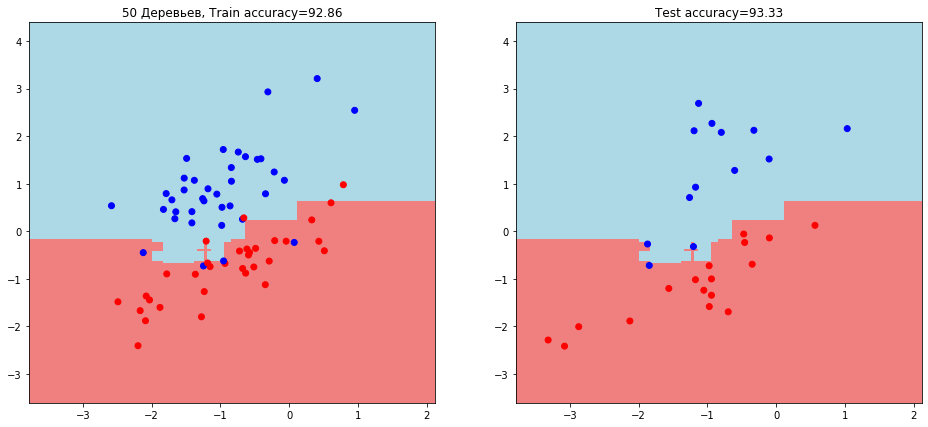

In [127]:
# Виз
visualize(my_forest_50, train_data, train_labels, train_accuracy_50, test_data, test_labels, test_accuracy_50, 50)

In [179]:
# Я бы еще на 100 попробовал )
# my_forest_100 = random_forest(train_data, train_labels, n_trees=100)
# train_answers_100 = tree_vote(my_forest_100, train_data)
# test_answers_100 = tree_vote(my_forest_100, test_data)

In [180]:
# Точность на трейне:
# train_accuracy_100 = accuracy_metric(train_labels, train_answers_100)
# train_accuracy_100

In [181]:
# И на тесте:
# test_accuracy_100 = accuracy_metric(test_labels, test_answers_100)
# test_accuracy_100

In [182]:
# Виз
# visualize(my_forest_100, train_data, train_labels, train_accuracy_100, test_data, test_labels, test_accuracy_100, 100)

Нда.. не похоже на какую-то внятную зависимость качества модели от количества деревьев.. Видимо все зависит каждый раз от конкретных данных и рандомного сида.

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [183]:
# Немного брут-форса:

accuracies = np.zeros((2, 49))
for n_trees in range(1, 50):
    random.seed(n_trees)

    my_forest_n = random_forest(train_data, train_labels, n_trees=n_trees)
    train_answers_n = tree_vote(my_forest_n, train_data)
    test_answers_n = tree_vote(my_forest_n, test_data)
    
    train_accuracy_n = accuracy_metric(train_labels, train_answers_n)
    test_accuracy_n = accuracy_metric(test_labels, test_answers_n)
    accuracies[0][n_trees-1] = train_accuracy_n
    accuracies[1][n_trees-1] = test_accuracy_n
    # visualize(my_forest_n, train_data, train_labels, train_accuracy_n, test_data, test_labels, test_accuracy_n, n_trees)


Text(0, 0.5, 'accuracy')

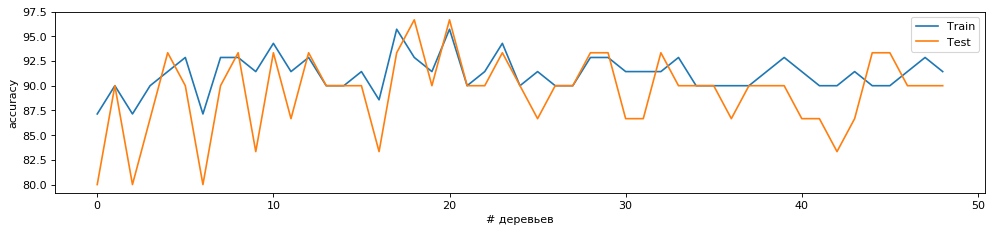

In [184]:
from matplotlib.pyplot import figure
figure(figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(accuracies[0], label='Train')
plt.plot(accuracies[1], label='Test')
plt.legend()
plt.xlabel('# деревьев')
plt.ylabel('accuracy')

Вобщем по поводу сложности гиперплоскости - очевидно, что при большем количестве деревьев она может быть сложнее (но не обязательно будет). Но по поводу пере или недообучености модели - сказать могу только, что на наших данных при количестве деревьев менее 10 шансы получить переобученную модель выше, чем когда количество деревьев больше 10..